In [18]:
from functools import partial
import torch.nn as nn
from model import get_generator
from supervised_tools.create_train_val_data import create_train_val_dataloaders
import numpy as np
import os
from torch_geometric.data import Data
import torch.nn.functional as F
from rdkit import Chem
from utils.setup import setup
import torch
print(torch.__version__)
import matplotlib.pyplot as plt
# from torch_lr_finder import LRFinder
from utils.data_utils import mols_from_file, get_atoms_info, rdkit2pyg, pyg2rdkit, save_smiles
from mappings import *
from train_functions import *


#! --- GET DATA ---
guacm_smiles = "/home/nobilm@usi.ch/master_thesis/guacamol/testdata.smiles"
train_guac_mols = mols_from_file(guacm_smiles, True)
train_data = rdkit2pyg(train_guac_mols[:32])


#! --- GET WEIGHTS ---
nweights = {
    'C':    0.03238897867833534,
    'Br':   14.044943820224718,
    'N':    0.21620219229022983,
    'O':    0.2177273617975571,
    'S':    1.6680567139282736,
    'Cl':   2.872737719046251,
    'F':    1.754693805930865,
    'P':    37.735849056603776,
    'I':    100.0,
    'B':    416.6666666666667,
    'Si':   454.54545454545456,
    'Se':   833.3333333333334
}
bweights = { 
    BT.SINGLE:      4.663287337775892, 
    BT.AROMATIC:    4.77780803722868, 
    BT.DOUBLE:      34.74514436607484, 
    BT.TRIPLE:      969.9321047526673 
}

nweights_list = [nweights[k] for k in atom2num]
bweights_list = [bweights[k] for k in bond2num]
bweights_list.insert(0, 1500)
node_weights = torch.tensor(nweights_list) 
edge_weights = torch.tensor(bweights_list) 

#! --- SET UP EXPERIMENT ---
LRrnn, LRout = 1e-5, 1e-5
wd = 5e-4
epoch, max_epoch = 1, 5

cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda:0" if cuda else "cpu")

train_dataset_loader, val_dataset_loader = create_train_val_dataloaders(train_data, train_data, max_num_node, max_prev_node) #! HERE WORKERS
rnn, output = get_generator()
rnn.apply(weight_init)
output.apply(weight_init)
rnn.ad_hoc_init()
output.ad_hoc_init()

optimizer_rnn = torch.optim.RMSprop(list(rnn.parameters()), lr=LRrnn, weight_decay=wd, eps=1e-5)
optimizer_output = torch.optim.RMSprop(list(output.parameters()), lr=LRout, weight_decay=wd, eps=1e-5)
scheduler_rnn = torch.optim.lr_scheduler.OneCycleLR(optimizer_rnn, max_lr=LRrnn, steps_per_epoch=len(train_dataset_loader), epochs=max_epoch)
scheduler_output = torch.optim.lr_scheduler.OneCycleLR(optimizer_output, max_lr=LRout, steps_per_epoch=len(train_dataset_loader), epochs=max_epoch)


2.0.1


[18:29:08] WARNING: no name column found on line 0
[18:29:08] WARNING: no name column found on line 1
[18:29:08] WARNING: no name column found on line 2
[18:29:08] WARNING: no name column found on line 3
[18:29:08] WARNING: no name column found on line 4
[18:29:08] WARNING: no name column found on line 5
[18:29:08] WARNING: no name column found on line 6
[18:29:08] WARNING: no name column found on line 7
[18:29:08] WARNING: no name column found on line 8
[18:29:08] WARNING: no name column found on line 9
[18:29:08] WARNING: no name column found on line 10
[18:29:08] WARNING: no name column found on line 11
[18:29:08] WARNING: no name column found on line 12
[18:29:08] WARNING: no name column found on line 13
[18:29:08] WARNING: no name column found on line 14
[18:29:08] WARNING: no name column found on line 15
[18:29:08] WARNING: no name column found on line 16
[18:29:08] WARNING: no name column found on line 17
[18:29:08] WARNING: no name column found on line 18
[18:29:08] WARNING: no

In [19]:
# for name, parameter in rnn.rnn.named_parameters():
#     if "weight_" in name: 
#         torch.nn.utils.parametrizations.weight_norm(rnn.rnn, name=name, dim=0)
        
# for name, parameter in output.rnn.named_parameters():
#     if "weight_" in name: 
#         torch.nn.utils.parametrizations.weight_norm(rnn.rnn, name=name, dim=0)

# By default, with dim=0, the norm is computed independently per output channel/plane. To compute a norm over the entire weight tensor, use dim=None.

In [20]:
# while epoch <= max_epoch:
    # loss_this_epoch, loss_edg, loss_nodes = train_rnn_epoch(rnn=rnn, output=output,
    #                                                         data_loader_=train_dataset_loader,
    #                                                         optimizer_rnn=optimizer_rnn, optimizer_output=optimizer_output,
    #                                                         node_weights=node_weights, edge_weights=edge_weights)
    # scheduler_rnn.step()
    # scheduler_output.step()
    # if epoch % 100 == 0: train_log.info(f'Epoch: {epoch}/{max_epoch}, sum of Loss: {loss_this_epoch:.8f}, loss edges {loss_edg:.8f}, loss nodes {loss_nodes:.8f}')
    # if VALIDATION and epoch % 100 == 0:
    #     loss_this_epoch, loss_edg, loss_nodes = validate_rnn_epoch(rnn, output, val_dataset_loader, node_weights, edge_weights)
    #     val_log.info(f'Epoch: {epoch}/{max_epoch}, sum of Loss: {loss_this_epoch:.8f}, loss edges {loss_edg:.8f}, loss nodes {loss_nodes:.8f}')
    # epoch += 1

In [21]:
# memorize_batch(epoch, max_epoch, rnn, output, train_dataset_loader, optimizer_rnn, optimizer_output, node_weights, edge_weights, scheduler_rnn, scheduler_output)
# Ns = [10]#, 60000, 110000, 160000, 210000]
# for i in Ns: generate_mols(i,rnn, output, epoch)


In [22]:
# # A hook executes a f that MUST takes 3 args: a module, an input and an output
# def _lsuv_stats(hook, module, inpt, outpt):
#     ''' For each layer stores mean/std'''
#     acts = to_cpu(outpt)
#     hook.mean = acts.mean()
#     hook.std = acts.std()

# def lsuv_init(activation_module, module_input_to_activation, xb):
#     '''
#     activation_module: module that contains the act func of the layer
#     module_input_to_activation: module that contain the weights used in activation_module
#     xb: batch    
#     '''    
#     h = Hook(activation_module, _lsuv_stats) # registers a forw_hook which executes _lsuv_stats
#     with torch.no_grad():
#         while(model(xb)) is not None and (abs(h.std-1)>1e-3 or abs(h.mean)>1e-3):
#             # modify weights untill activated layer has m=0, std=1
#             module_input_to_activation.bias -= h.mean
#             module_input_to_activation.weight.data /= h.std
#     h.remove()    

# Activations analysis

In [23]:
layer_means_rnn = {}
layer_stds_rnn = {}
layer_hists_rnn = {}
for idx, (name, module) in enumerate(rnn.named_children()):
    if isinstance(module, nn.GRU):
        for ii in range(0,2):
            layer_means_rnn[f'{name}_output_{idx}'] = []
            layer_means_rnn[f'{name}_hidden_{idx}'] = []
            layer_stds_rnn[f'{name}_output_{idx}'] = []
            layer_stds_rnn[f'{name}_hidden_{idx}'] = []
            layer_hists_rnn[f'{name}_hidden_{idx}'] = []
    else:
        layer_means_rnn[name] = []
        layer_stds_rnn[name] = []
        layer_hists_rnn[name] = []


def append_(idx, name, module, input, output):
    if isinstance(module, nn.GRU):        
        layer_means_rnn[f'{name}_output_{idx}'].append(output[0].data.detach().cpu().numpy().mean())
        layer_stds_rnn[f'{name}_output_{idx}'].append(output[0].data.detach().cpu().numpy().std())
        layer_means_rnn[f'{name}_hidden_{idx}'].append(output[1].data.detach().cpu().numpy().mean())
        layer_stds_rnn[f'{name}_hidden_{idx}'].append(output[1].data.detach().cpu().numpy().std())
        
        layer_hists_rnn[f'{name}_hidden_{idx}'].append(output[0].data.detach().cpu().abs().histc(40,0,10))        
    else:
        layer_means_rnn[name].append(output.detach().cpu().numpy().mean())
        layer_stds_rnn[name].append(output.detach().cpu().numpy().std())
        layer_hists_rnn[name].append(output.detach().cpu().abs().histc(40,0,10))

In [24]:
for idx, (module_name, module) in enumerate(rnn.named_children()):
    module.register_forward_hook(partial(append_, idx, module_name))

In [25]:
epoch = 0
while epoch < max_epoch:
    loss_edg, loss_nodes = train_rnn_epoch(rnn=rnn, output=output,
                                                            data_loader_=train_dataset_loader,
                                                            optimizer_rnn=optimizer_rnn, optimizer_output=optimizer_output,
                                                            node_weights=node_weights, edge_weights=edge_weights,
                                                            rnn_scheduler= scheduler_rnn, output_scheduler= scheduler_output
                                                            )
    print(f"Epoch {epoch}, loss_edg: {loss_edg}, loss_nodes: {loss_nodes}")
    epoch +=1

Epoch 0, loss_edg: 0.5557506680488586, loss_nodes: 0.2907046377658844
Epoch 1, loss_edg: 0.5549735426902771, loss_nodes: 0.29057538509368896
Epoch 2, loss_edg: 0.525888204574585, loss_nodes: 0.2859339714050293
Epoch 3, loss_edg: 0.5020628571510315, loss_nodes: 0.2824395000934601
Epoch 4, loss_edg: 0.49308106303215027, loss_nodes: 0.2812100052833557


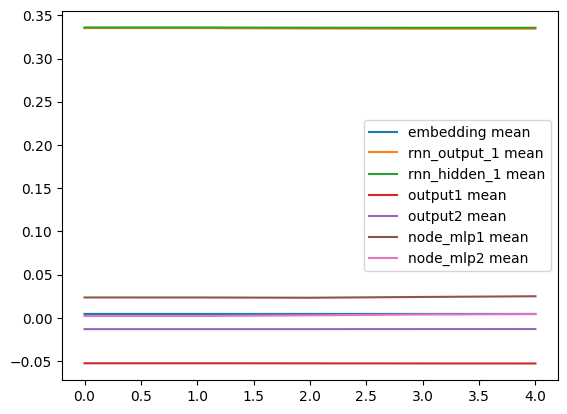

In [27]:
# figsize = 100
for color, k in enumerate(layer_means_rnn.keys()):
    plt.plot([i for i in range(len(layer_means_rnn[k]))], layer_means_rnn[k], label=f'{k} mean'.format(i=color))
plt.legend(loc='best')

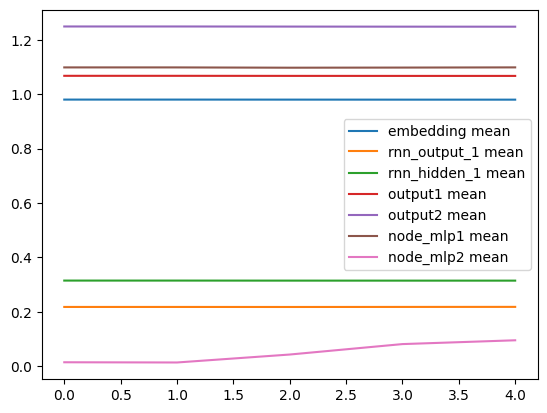

In [29]:
for color, k in enumerate(layer_hists_rnn.keys()):
    plt.plot([i for i in range(len(layer_stds_rnn[k]))], layer_stds_rnn[k], label=f'{k} mean'.format(i=color))
plt.legend(loc='best')

In [30]:
def get_hist(h):  return torch.stack(h).t().float().log1p() # with log you can see the range more clearly

AttributeError: Line2D.set() got an unexpected keyword argument 'origin'

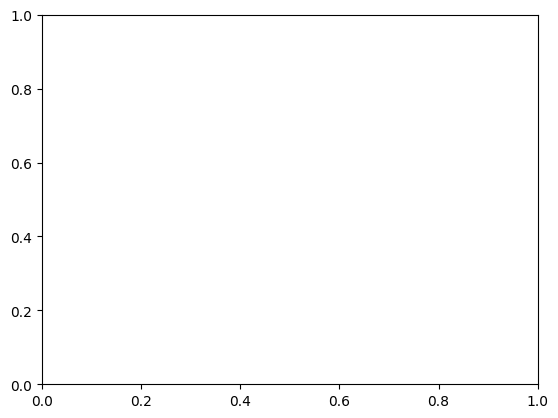

In [45]:
# fig, axes = plt.subplots(2,3, figsize=figsize)
plt.plot(get_hist(layer_hists_rnn[k]), origin='lower')


AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

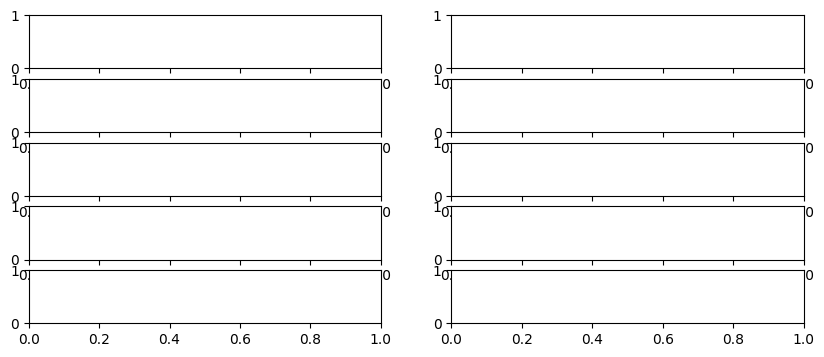

In [41]:
fig,axs = plt.subplots(5,2, figsize=(10,4))

axs.imshow(get_hist(layer_hists_rnn[k]aa))


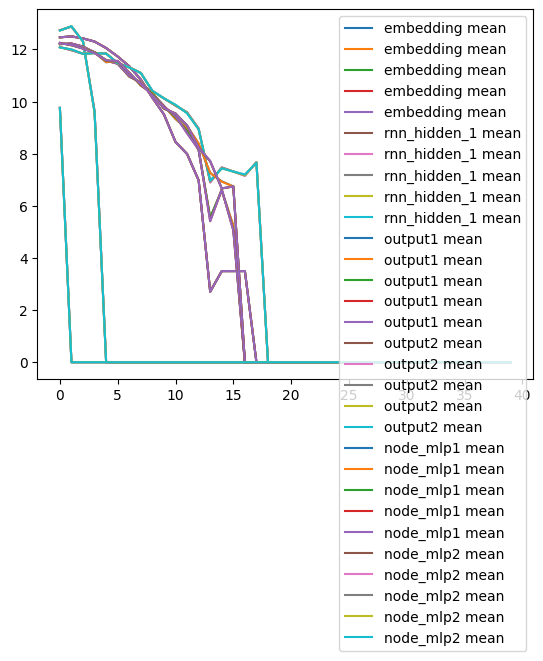

In [36]:
for color, k in enumerate(layer_hists_rnn.keys()):
    plt.plot(get_hist(layer_hists_rnn[k]), label=f'{k} mean'.format(i=color))


plt.legend(loc='best')